In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline
sns.set(style='ticks', font_scale=1.7)
from IPython.display import display
from ipywidgets import interact, widgets

In [15]:
def tridiag(a, b, c):
    """
    Строит матрицу по трем данным диагоналям
    :param a: под главной (size = n-1)
    :param b: главная (size = n)
    :param c: над главной (size = n-1)
    :return: матрица (n x n)
    """
    return np.diag(a, k=-1) + np.diag(b, k=0) + np.diag(c, k=1)

In [16]:
def progonka(a, b, c, f):
    """
    Метод прогонки
    :param a: диагональ, лежащая под главной (size = n-1)
    :param b: главная диагональ (size = n)
    :param c: диагональ, лежащая над главной (size = n-1)
    :param f: вектор свободных членов (size = n)
    :return: вектор неизвестых y
    """
    n = len(f)
    alpha = np.zeros(n-1)
    beta = np.zeros(n)
    alpha[0] = c[0] / b[0]
    beta[0] = f[0] / b[0]

    # прямая прогонка
    for i in range(1, n-1):
        alpha[i] = c[i] / (b[i] - a[i-1]*alpha[i-1])
        beta[i] = (f[i] - a[i-1]*beta[i-1]) / (b[i] - a[i-1]*alpha[i-1])
    
    beta[n-1] = (f[n-1] - a[-1]*beta[n-2]) / (b[n-1] - a[-1]*alpha[-1])
    
    # обратная прогонка
    y = np.zeros(n)
    y[-1] = beta[-1]
    
    for i in range(n-2, -1, -1):
        y[i] = beta[i] - alpha[i] * y[i+1]
        
    return y

In [17]:
# константы
dz = 10
B = 50
L = 500
p_0 = 100 * (10**5)
p_inj = 150 * (10**5)
p_prod = 50 * (10**5)

fi = 0.2
k = 1e-14
mu = 1e-3 / 86400 
c_f = 1e-9
rho_0 = 1000
p_oporn = 120 * (10**5)

In [18]:
def rho(p):
    return rho_0 * (1 + c_f * (p-p_oporn))

In [19]:
# параметры сетки
tau = 0.01
h = 5
T = 10

n_t = int(T / tau) + 1
n_x = int(L / h) + 1

p = np.zeros((n_t, n_x))

In [20]:
p[0, :] = p_0
p[:, 0] = p_inj
p[:, -1] = p_prod

In [21]:
c = np.zeros(n_x)  # c[0] не используется
b = np.zeros(n_x)  # b[-1] не используется
a = np.zeros(n_x)
d = np.zeros(n_x)
a[0] = 1
b[0] = 0
a[-1] = 1
c[-1] = 0
d[0] = p_inj
d[-1] = p_prod

for n in tqdm(range(n_t-1)):
    for i in range(1, n_x-1):
        
        if p[n, i] >= p[n, i+1]:
            rho_plus = rho(p[n, i])
        else:
            rho_plus = rho(p[n, i+1])
        if p[n, i-1] >= p[n, i]:
            rho_minus = rho(p[n, i-1])
        else:
            rho_minus = rho(p[n, i])
            
        c[i] = (k * rho_minus) / (mu * h**2)
        b[i] = (k * rho_plus) / (mu * h**2)
        a[i] = - c[i] - b[i] - ((fi * c_f * rho_0) / tau)
        d[i] = - ((fi * c_f * rho_0) / tau) * p[n, i]
    
    p[n+1, :] = progonka(c[1:], a, b[:-1], d)
        

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
x = np.arange(0, L+h, h)
t = np.arange(0, T+tau, tau)

In [23]:
@interact(time=widgets.FloatSlider(value=0, min=0, max=10, step=0.01))

def visualize(time):
    plt.figure(figsize=(15, 7))

    index = np.where(np.abs(t - time) <= 1e-6)[0][0]

    plt.plot(x, p[index, :], label=f'time = {time} days')
    plt.xlabel('x, м')
    plt.ylabel('P, Па')
    plt.legend()    
    plt.grid()

interactive(children=(FloatSlider(value=0.0, description='time', max=10.0, step=0.01), Output()), _dom_classes…

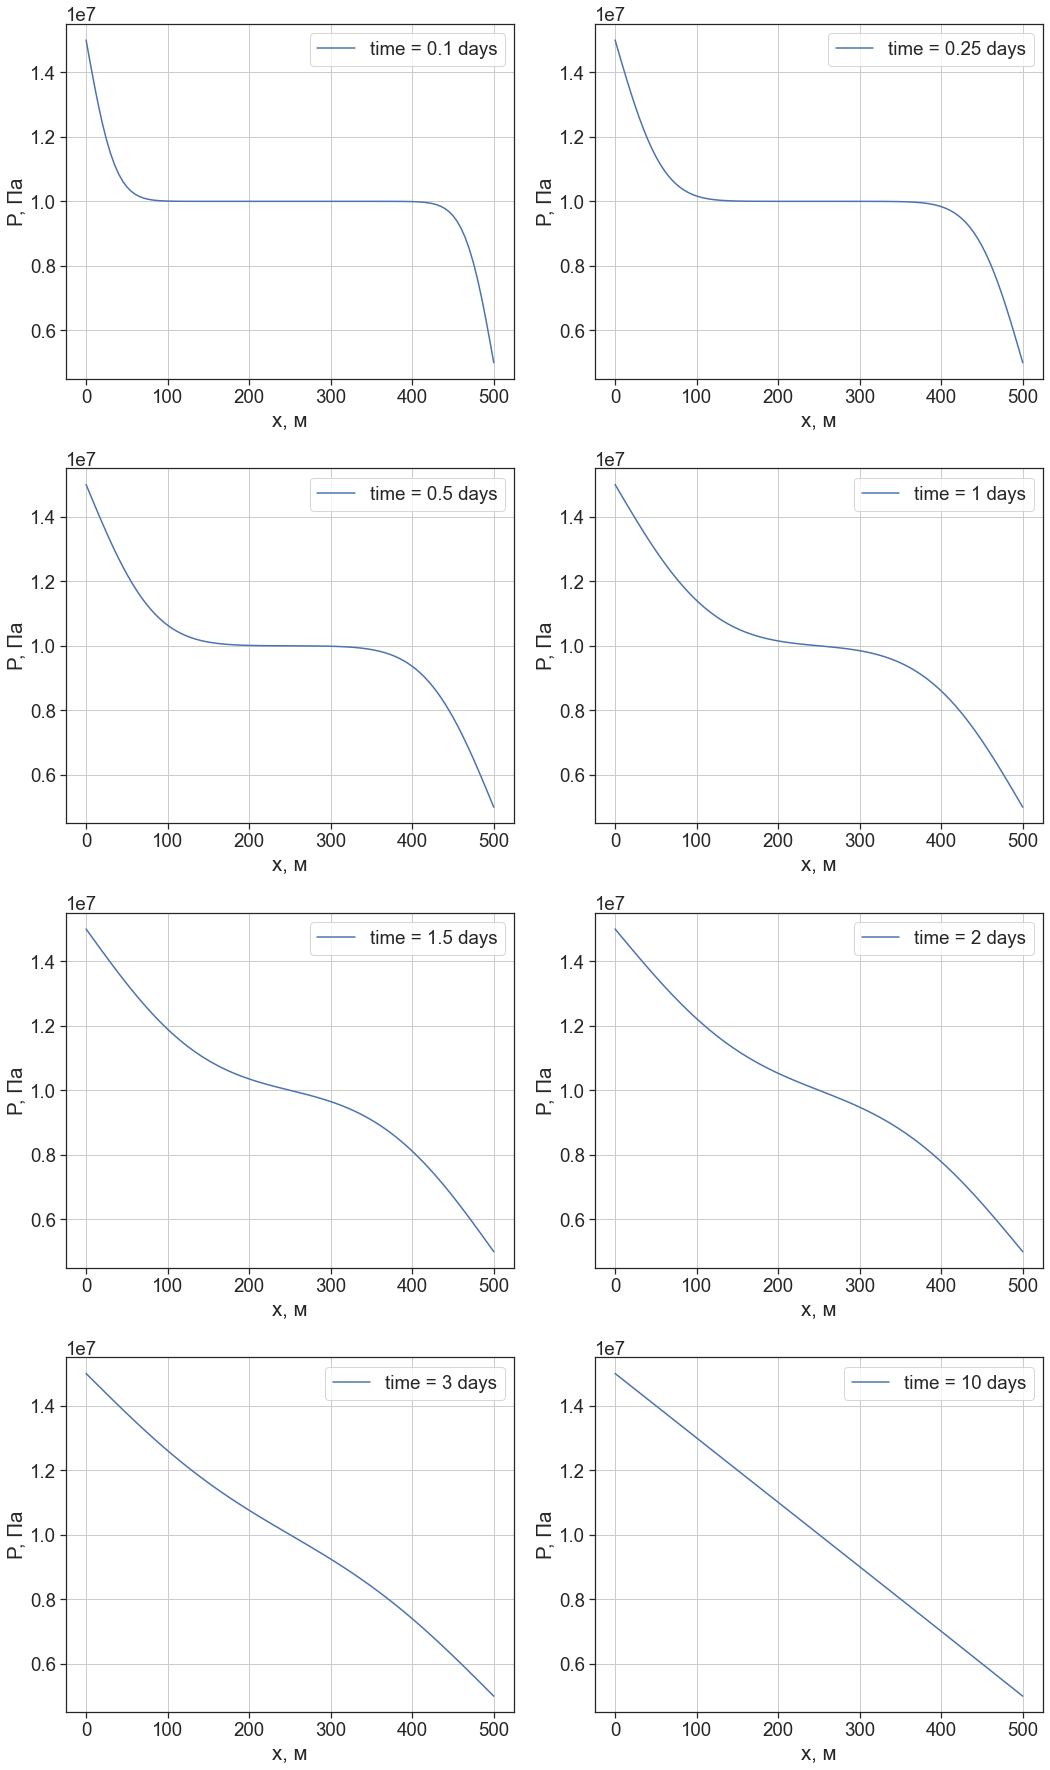

In [24]:
t_view = [0.1, 0.25, 0.5, 1, 1.5, 2, 3, 10]

plt.figure(figsize=(15, 25))

for i in range(len(t_view)):
    index = np.where(np.abs(t - t_view[i]) <= 1e-6)[0][0]
    
    plt.subplot(4, 2, i+1)
    plt.plot(x, p[index, :], label=f'time = {t_view[i]} days')
    plt.xlabel('x, м')
    plt.ylabel('P, Па')
    plt.legend()    
    plt.grid()

plt.tight_layout()